## Chess Neural Network EDA

This notebook provides an exploratory data analysis (EDA) of the chess datasets from my own online chess games **(Lichess + Chess.com)**, which were used for training neural networks (NNUE architectures) for chess position evaluation. It not only explores the dataset, but also documents the decision-making process, especially regarding on capping evaluation values for the later encoding sections, which can be found in the training scripts. 

---

### Table of Contents

1. [Introduction](#1)
2. [Data Loading and Overview](#2)
3. [Exploratory Data Analysis](#3)

---

<a id='1'></a>
### 1. Introduction

In this project, we trained neural networks based on the NNUE (Efficiently Updatable Neural Network) architecture to evaluate chess positions:

- **Model**: Trained using `training_nnue_1144.py` with 1144 features.

The main goal is to develop a chess engine that has only seen my games for training and capable of mimicking my chess style, even in yet unseen positions, generalizing just as much that it theoretically allows someone else to play against me, without actually playing against me. For training, roughly 15000 of my games, from a span of 7 years were used.

This notebook analyzes these games, shows some of the reasons behind the decisions made during model development.

---

<a id='2'></a>
### 2. Data Loading and Overview

In [8]:
# Our required mports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import chess

# Visual settings for seaborn
sns.set(style="whitegrid")

In [9]:
lichess_file = "evaluated_positions/lichess_evaluations.txt"
chesscom_file = "evaluated_positions/chesscom_evaluations.txt"

# Our function that prepares the FEN formatted text files for reading
def load_evaluation_file(filepath):
    with open(filepath, "r") as f:
        data = []
        for line in f:
            parts = line.strip().split(" | ")
            if len(parts) == 2:
                fen, evaluation = parts
                evaluation = float(evaluation.split(": ")[1])
                data.append([fen, evaluation])
    return pd.DataFrame(data, columns=["FEN", "Evaluation"])

# Allows us to load and combine both datasets. In my case, lichess and chess.com exports.
lichess_data = load_evaluation_file(lichess_file)
chesscom_data = load_evaluation_file(chesscom_file)
combined_data = pd.concat([lichess_data, chesscom_data], ignore_index=True)

# Data Overview
print("Lichess Data Shape:", lichess_data.shape)
print("Chess.com Data Shape:", chesscom_data.shape)
print("Combined Data Shape:", combined_data.shape)

Lichess Data Shape: (123295, 2)
Chess.com Data Shape: (498347, 2)
Combined Data Shape: (621642, 2)


In [10]:
combined_data.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...,-33.0
1,rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...,37.0
2,rnbqkbnr/ppp1pppp/8/3p4/2PP4/8/PP2PPPP/RNBQKBN...,-30.0
3,rnbqkbnr/ppp1pppp/8/8/2pP4/8/PP2PPPP/RNBQKBNR ...,42.0
4,rnbqkbnr/ppp1pppp/8/8/2pP1B2/8/PP2PPPP/RN1QKBN...,16.0


<a id='3'></a>
### 3. Exploratory Data Analysis

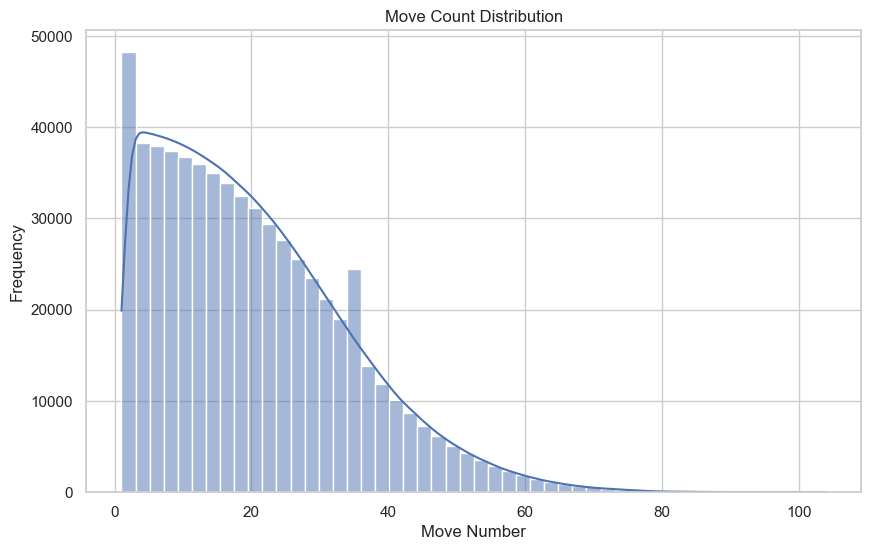

In [11]:
# Let's start by checking move count distribution (extracted from the FEN strings)
def extract_move_number(fen):
    return int(fen.split()[-1])

combined_data['MoveNumber'] = combined_data['FEN'].apply(extract_move_number)

# Let's plot it.
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['MoveNumber'], bins=50, kde=True)
plt.title('Move Count Distribution')
plt.xlabel('Move Number')
plt.ylabel('Frequency')
plt.show()

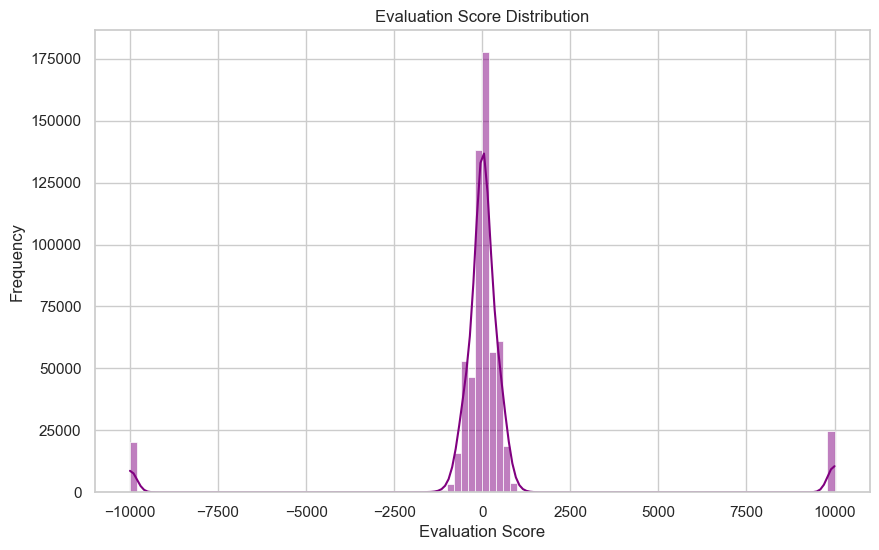

Correlation between Move Number and Evaluation: 0.0202


In [8]:
# Now is the actual interesting part, how well did Stockfish do the evaluations? Let's check the evaluation distributions.
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['Evaluation'], bins=100, kde=True, color="purple")
plt.title('Evaluation Score Distribution')
plt.xlabel('Evaluation Score')
plt.ylabel('Frequency')
plt.show()

# Corr: Is there a possible correlation between move number and evaluation in any way? I would think no, and our data confirms it!
correlation = combined_data['MoveNumber'].corr(combined_data['Evaluation'])
print(f"Correlation between Move Number and Evaluation: {correlation:.4f}")

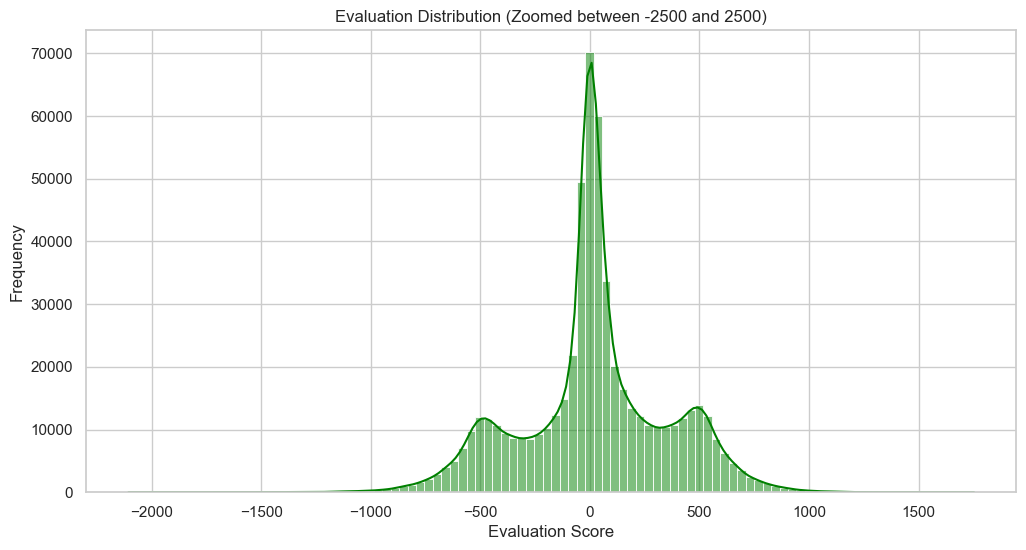

In [12]:
# One interesting thing above, was the existence of data on both extreme ends. Understanding this part will be crucial for our NNUE encodings.

# Before that though, let us make sure we first understand the "bell", the core of our evaluations correctly. Which seems to be reasonable, as the plot below shows.
plt.figure(figsize=(12, 6))
sns.histplot(combined_data[(combined_data['Evaluation'] >= -2500) & (combined_data['Evaluation'] <= 2500)]['Evaluation'], 
             bins=100, kde=True, color="green")
plt.title('Evaluation Distribution (Zoomed between -2500 and 2500)')
plt.xlabel('Evaluation Score')
plt.ylabel('Frequency')
plt.show()

Mate-in-X cases among extreme values: 2378
Non-Mate-in-X cases among extreme values: 42970


C:\Users\ozgot\AppData\Local\Temp\ipykernel_10628\3539435302.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_values['Mate'] = extreme_values['FEN'].apply(detect_mate_in_x)


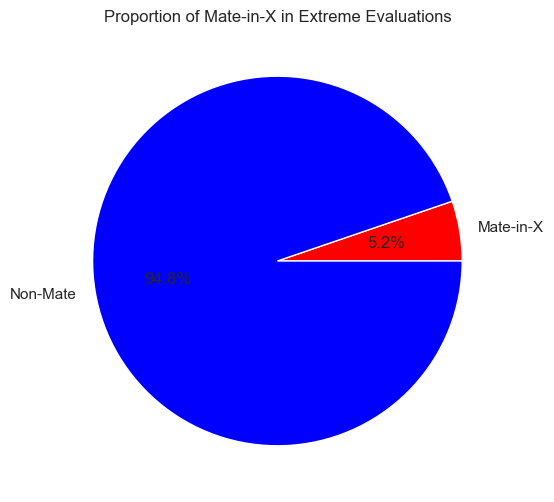

In [14]:
# Coming back to the extremes - let's call this section: Mate-in-X Scenarios
# If you are new to chess, chess engines usually switch from the normal float valued evaluations to things like: M1 (Mate in 1), M6 etc. like sequences.
# This only happens, if there is a forced mate pattern in the game. I really wondered if this was the sole reason why Stockfish assigned such high values to some positions.
# Below code checks if these extreme values correspond to forced mate sequences. (**spoiler alert**, not all!)

def detect_mate_in_x(fen):
    board = chess.Board(fen)
    if board.is_checkmate():
        return True
    return False

# Now let us apply this to the extreme evaluated rows in the dataset.
extreme_values = combined_data[(combined_data['Evaluation'] > 5000) | (combined_data['Evaluation'] < -5000)]
extreme_values['Mate'] = extreme_values['FEN'].apply(detect_mate_in_x)

# Let us "calculate" how many extreme values are likely "Mate-in-X" cases
mate_count = extreme_values['Mate'].sum()
non_mate_count = len(extreme_values) - mate_count

print(f"Mate-in-X cases among extreme values: {mate_count}")
print(f"Non-Mate-in-X cases among extreme values: {non_mate_count}")

# Time to visualize the findings.
plt.figure(figsize=(6, 6))
plt.pie([mate_count, non_mate_count], labels=['Mate-in-X', 'Non-Mate'], autopct='%1.1f%%', colors=["red", "blue"])
plt.title("Proportion of Mate-in-X in Extreme Evaluations")
plt.show()

Capping evaluations to a range of -5000 to 5000 can help avoid these extreme situations, as they often represent game-ending scenarios.


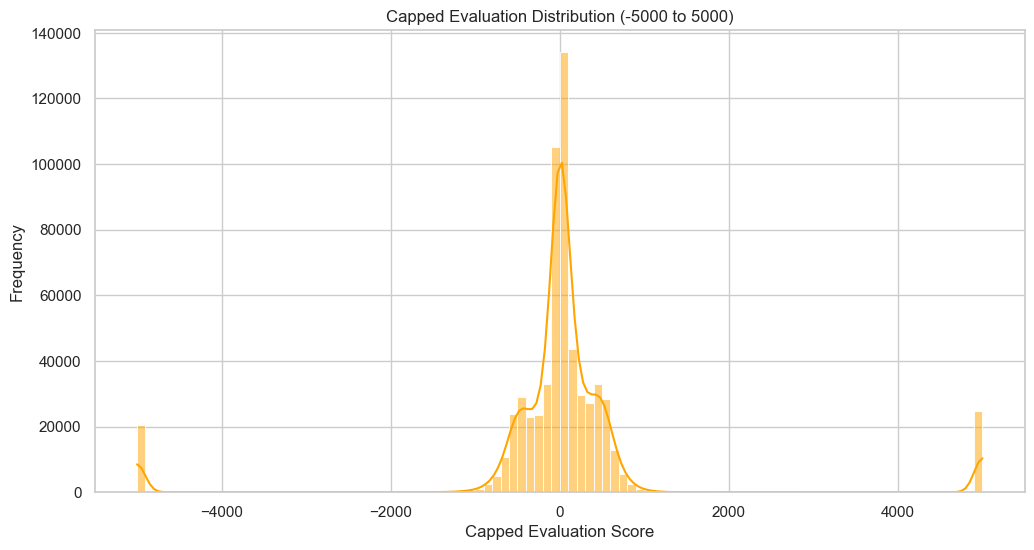

In [15]:

"""

Capping Logic Justification:
Based on these findings, it appears that the majority of the extreme values are likely representing either
Mate-in-X sequences or positions with an overwhelming advantage. Thus, capping the evaluations makes sense.

"""

print("Capping evaluations to a range of -5000 to 5000 can help avoid these extreme situations, as they often represent game-ending scenarios.")
combined_data['CappedEvaluation'] = combined_data['Evaluation'].clip(-5000, 5000)

# Let's visualize the capped evaluations.
plt.figure(figsize=(12, 6))
sns.histplot(combined_data['CappedEvaluation'], bins=100, kde=True, color="orange")
plt.title('Capped Evaluation Distribution (-5000 to 5000)')
plt.xlabel('Capped Evaluation Score')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Finally, let us check some base statistics. Especially, from the variance point of view.
mean_eval = combined_data['Evaluation'].mean()
std_eval = combined_data['Evaluation'].std()
var_eval = combined_data['Evaluation'].var()
median_eval = combined_data['Evaluation'].median()
min_eval = combined_data['Evaluation'].min()
max_eval = combined_data['Evaluation'].max()

print(f"Mean Evaluation: {mean_eval:.2f}")
print(f"Standard Deviation of Evaluation: {std_eval:.2f}")
print(f"Variance of Evaluation: {var_eval:.2f}")
print(f"Median Evaluation: {median_eval:.2f}")
print(f"Minimum Evaluation: {min_eval:.2f}")
print(f"Maximum Evaluation: {max_eval:.2f}")

# Percentages of Extreme Evaluations (>5000 or <-5000) compared to rest.
extreme_eval_count = len(extreme_values)
total_eval_count = len(combined_data)
extreme_eval_percentage = (extreme_eval_count / total_eval_count) * 100

print(f"Percentage of Extreme Evaluations (>5000 or <-5000): {extreme_eval_percentage:.2f}%")

# Proportion of Evaluations in Various Ranges
ranges = [-5000, -2500, -1000, -500, 0, 500, 1000, 2500, 5000]
combined_data['BinnedEval'] = pd.cut(combined_data['Evaluation'], bins=ranges)
eval_counts = combined_data['BinnedEval'].value_counts().sort_index()

# Here, let's see how the extremes behave compared to the overall data.
extreme_mean_eval = extreme_values['Evaluation'].mean()
extreme_std_eval = extreme_values['Evaluation'].std()
extreme_var_eval = extreme_values['Evaluation'].var()

print(f"Mean of Extreme Evaluations: {extreme_mean_eval:.2f}")
print(f"Standard Deviation of Extreme Evaluations: {extreme_std_eval:.2f}")
print(f"Variance of Extreme Evaluations: {extreme_var_eval:.2f}")

# Let's compare the variance of the normal range (-5000 to 5000) with the extreme range (>5000 or <-5000)
normal_evals = combined_data[(combined_data['Evaluation'] <= 5000) & (combined_data['Evaluation'] >= -5000)]
extreme_evals = combined_data[(combined_data['Evaluation'] > 5000) | (combined_data['Evaluation'] < -5000)]

normal_var = normal_evals['Evaluation'].var()
extreme_var = extreme_evals['Evaluation'].var()

print(f"Variance of Normal Evaluations (-5000 to 5000): {normal_var:.2f}")
print(f"Variance of Extreme Evaluations (>5000 or <-5000): {extreme_var:.2f}")

Mean Evaluation: 89.05812348586485
Standard Deviation of Evaluation: 2716.6677066244997
Variance of Evaluation: 7380283.428216419
Median Evaluation: 14.0
Minimum Evaluation: -10000.0
Maximum Evaluation: 9999.0
Percentage of Extreme Evaluations (>5000 or <-5000): 7.29%
Mean of Extreme Evaluations: 974.176678133545
Standard Deviation of Extreme Evaluations: 9946.593006524243
Variance of Extreme Evaluations: 98934712.43743698
Variance of Normal Evaluations (-5000 to 5000): 109617.08996652083
Variance of Extreme Evaluations (>5000 or <-5000): 98934712.43743698
